In [11]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn3
import mca
import matplotlib.pyplot as plt
from collections import Counter

In [39]:
class Compare:
    def __init__ (self, collections, names=None, index=[]):
        self.collection_names = names
        self.index = index
        self.collections = collections
        # if a dictionary is inputed, then get names from dictionary
        if isinstance(self.collections, dict):
            self.collection_names = [x for x in self.collections.keys()]
            self.collections = [x for x in self.collections.values()]
        # if index var is provided, use index to filter collection list
        if self.index:
            self.collections = self.sublist(self.collections, self.index)
            self.collection_names = self.sublist(self.collection_names, self.index)
        #two sample venn
        if len(self.collections) == 2:
            self.response = self.two_venn(self.collections)
        #three sample venn
        elif len(self.collections) == 3:
            self.three_venn(self.collections)
        #use mca for greater than three
        elif len(self.collections) >3:
            self.ca = self.ca(self.collections, self.collection_names)
        else:
            print ("Need at least two collections to compare results.")
    
    #get a sublist from a list of indices
    def sublist (self, list1, list2):
        return([list1[x] for x in list2])        
    #get set of all items (unduplicated)
    def unionize (self, sets_list):
        return set().union(*sets_list)
    def two_venn (self, collections):
        return  (venn2([set(x) for x in collections], set_labels=self.collection_names))
    def three_venn (self, collections):
        return  (venn3([set(x) for x in collections], set_labels=self.collection_names))
    def ca(self, collections, names):
        # use dd to create dataframe
        dd = self.unionize(collections)
        d = []
        fs, cos, cont = 'Factor Score','Squared cosines', 'Contributions x 1000'
        #populate table with matches for actors (weblists)
        for y in collections:
            d.append({x: x in y for x in dd})
        df = pd.DataFrame(d, index=names)
        counts = mca.mca(df)
        data = pd.DataFrame(columns=df.index, index=pd.MultiIndex
                      .from_product([[fs, cos, cont], range(1, 3)]))
        data.loc[fs,    :] = counts.fs_r(N=2).T
        points = data.loc[fs].values
        labels = data.columns.values

        plt.figure(figsize=(10,10))
        plt.margins(0.1)
        plt.axhline(0, color='gray')
        plt.axvline(0, color='gray')
        plt.xlabel('Factor 1')
        plt.ylabel('Factor 2')
        plt.scatter(*points, s=120, marker='o', c='r', alpha=.5, linewidths=0)
        for label, x, y in zip(labels, *points):
            plt.annotate(label, xy=(x, y), xytext=(x + .03, y + .03))
        plt.show()
        return(df.T)
        

In [40]:
collection = dict()
path = "data/"
for filename in os.listdir(path):
    file = open(path+filename, "r")
    collect = [line.translate(str.maketrans(')'," ")).split(",")[2] for line in file.readlines()[0:5000]]
    collection[filename[0:10]] = (collect)
    print(filename)




    
    

alberta_education_curriculum-links.txt
alberta_floods_2013-links.txt
alberta_oil_sands-links.txt
canadian_business_grey_literature-links.txt
elxn42-links.txt
energy_environment-links.txt
hcf_alberta_online_encyclopedia-links.txt
health_sciences_grey_literature-links.txt
heritage_community_foundation-links.txt
humanities_computing-links.txt
lfrancophonie_de_louest_canadien-links.txt
ottawa_shooting_october_2014-links.txt
prarie_provinces-links.txt
web_archive_general-links.txt


In [4]:


collection1 = ["google", "apple", "microsoft", "msn", "napster", "oracle", "amazon", "ibm"]
collection2 = ["google", "pear", "thebeatles", "thepogues", "napster", "apple", "cow"]
collection3 = ["google", "apple", "msn", "skunk", "beaver", "wolf", "cow"]
collection4 = ["apple", "jump", "walk", "run", "saunter", "skunk", "napster"]
collection5 = ["pear", "wolf", "jive", "tango"]
collection6 = ["google", "apple", "msn", "thepogues", "napster", "wolf", "amazon", "tango"]

one_collect = [collection1]
two_collect = [collection1, collection2]
three_collect = [collection1, collection2, collection3]
all_collect = [collection1, collection2, collection3, collection4, collection5, collection6]

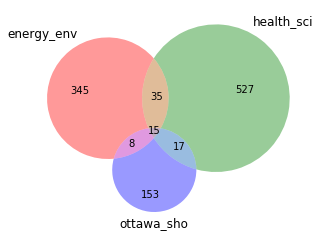

In [36]:
#Venn diagram for two collections
#A has 8 items; B has 7. They have 3 in common.
comparit = [x for x in collection.values()]
names = [x for x in collection.keys()]
compare1 = Compare(comparit, names, [0,6,8])


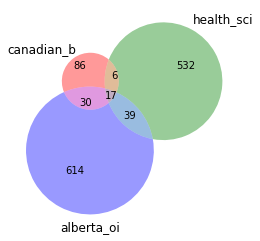

In [37]:
# What happens with three collections
compare2 = Compare(comparit, names, [1,6,10])


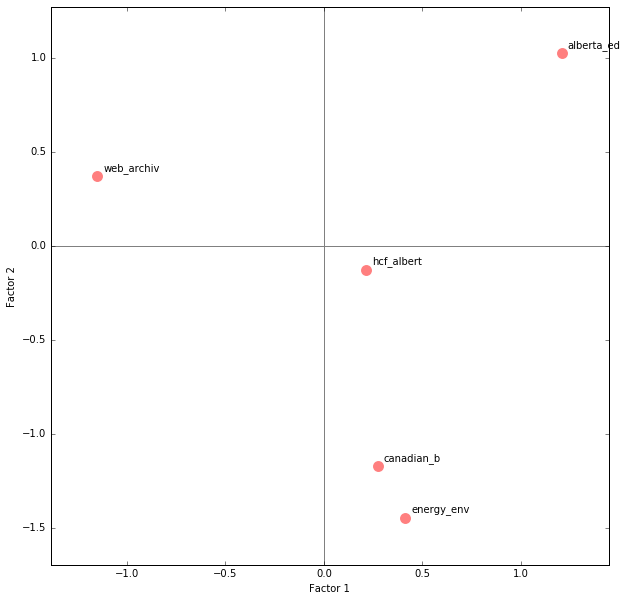

In [38]:
# With more than three collections, the output switches to correspondence analysis.
# Katherine Faust offers a great overview of the method here:
# www.socsci.uci.edu/~kfaust/faust/research/articles/articles.htm
# In this case, collection 2, 3 & 6 have more in common with each other than with the other collections, so
# would be the best possible consideration for a common social network analysis.
# Collection 1 may be another consideration.
del (collection['humanities'])
compare3 = Compare(collection, names, [0,1,3,10,11])

In [28]:
# Just to show the table of who matches with whom.
print (compare3.ca[0:10])

                                            energy_env canadian_b heritage_c  \
%                                                False      False      False   
0-proquest.umi.com.aupac.lib.athabascau.ca       False      False      False   
006ec10.netsolhost.com                           False      False      False   
0451shouji.com                                   False      False      False   
0523seo.cn                                       False      False      False   
0816-geschenke.ch                                False      False      False   
0851idc.cn                                       False      False      False   
0l3.de                                           False      False      False   
1-massage.ru                                     False      False      False   
1.bp.blogspot.com                                False      False      False   

                                            hcf_albert prarie_pro elxn42-lin  \
%                                      